<a href="https://colab.research.google.com/github/alisoufali/neural_networks_with_pytorch/blob/main/codes/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn

print(torch.__version__)

2.0.1+cu118


In [ ]:
%matplotlib inline
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
mpl.rcParams["figure.dpi"] = 120

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Defining Functions

In [ ]:
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    number_corrects = torch.eq(y_pred, y_true).sum().item()
    accuracy = 100 * number_corrects/(y_true.shape[0])
    return accuracy

In [ ]:
def plot_decision_boundary(
        model: nn.Module, X: torch.Tensor, y: torch.Tensor,
        fig: Figure | None, ax: Axes | None,
        n_grids_dim: int = 100) -> None:

    original_device = next(model.parameters()).device

    model = model.to("cpu")
    X = X.to("cpu")
    y = y.to("cpu")

    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    x1s, x2s = np.meshgrid(np.linspace(x1_min, x1_max, n_grids_dim+1),
                           np.linspace(x1_min, x1_max, n_grids_dim+1))

    X_to_pred = torch.from_numpy(
        np.column_stack((x1s.ravel(), x2s.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred)
        if len(torch.unique(y)) > 2:
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        else:
            y_pred = torch.round(torch.sigmoid(y_logits))
        y_pred = y_pred.reshape(x1s.shape).detach().numpy()

    if (fig is None) or (ax is None):
        fig, ax = plt.subplots()

    cmap = mpl.colormaps["RdYlBu"]
    ax.contourf(x1s, x2s, y_pred, cmap=cmap, alpha=0.7)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap)
    ax.set_xlim(x1s.min(), x1s.max())
    ax.set_ylim(x2s.min(), x2s.max())

    model = model.to(original_device)
    X = X.to(original_device)
    y = y.to(original_device)

# Making Classification Data and Splitting it

## Creating Dataset

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=55)

print(f"X shape: {X.shape},     y shape: {y.shape}")
print(f"First 10 samples in X: {X[:10]}")
print(f"First 10 samples in y: {y[:10]}")

X shape: (1000, 2),     y shape: (1000,)
First 10 samples in X: [[ 0.84185974 -0.50240901]
 [ 0.11561202 -0.967942  ]
 [ 0.71458802  0.27456366]
 [ 0.19204725 -0.77725032]
 [-0.96940563  0.14870034]
 [-0.37314861  0.96680263]
 [-0.79816716 -0.63172354]
 [ 0.78966633  0.1246774 ]
 [ 0.76592405  0.26328553]
 [ 0.43167976 -0.67060159]]
First 10 samples in y: [0 0 1 1 0 0 0 1 1 1]


In [ ]:
data = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

In [ ]:
data

X1        X2  label
0    0.841860 -0.502409      0
1    0.115612 -0.967942      0
2    0.714588  0.274564      1
3    0.192047 -0.777250      1
4   -0.969406  0.148700      0
..        ...       ...    ...
995  0.162557 -0.793411      1
996  0.714143 -0.313161      1
997 -0.830686 -0.545210      0
998 -0.382222  0.699224      1
999  0.901243 -0.435972      0

[1000 rows x 3 columns]

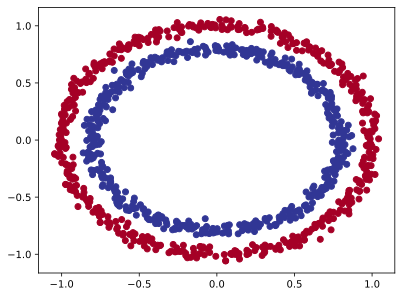

In [ ]:
fig, ax = plt.subplots()

cmap = mpl.colormaps["RdYlBu"]
scatter_plot = ax.scatter(x=data["X1"], y=data["X2"],
                          c=data["label"], cmap=cmap)

In [ ]:
X

array([[ 0.84185974, -0.50240901],
       [ 0.11561202, -0.967942  ],
       [ 0.71458802,  0.27456366],
       ...,
       [-0.8306856 , -0.54520955],
       [-0.38222194,  0.69922429],
       [ 0.90124277, -0.4359716 ]])

In [ ]:
y

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,

In [ ]:
X_sample = X[15]
y_sample = y[15]

print(X_sample.shape, y_sample.shape)

(2,) ()


## Turning Dataset into Tensor Format and Splitting It

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
X_train.device

device(type='cpu')

# Model V1

## Creating a Model

In [ ]:
class CircleModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=5)
        self.linear_layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = self.linear_layer_2(self.linear_layer_1(x))
        return result

In [ ]:
model = CircleModel()
model.to(device)

print(next(model.parameters()).device)

cpu


In [ ]:
model.state_dict()

OrderedDict([('linear_layer_1.weight',
              tensor([[-0.5047,  0.1733],
                      [ 0.3058,  0.5203],
                      [ 0.2668,  0.4940],
                      [-0.5896,  0.4937],
                      [-0.2306, -0.0980]])),
             ('linear_layer_1.bias',
              tensor([ 0.4615,  0.0662,  0.6039,  0.3976, -0.6303])),
             ('linear_layer_2.weight',
              tensor([[-0.0135, -0.2640, -0.2459, -0.2227,  0.3643]])),
             ('linear_layer_2.bias', tensor([0.0725]))])

In [ ]:
model.eval()

with torch.inference_mode():
    y_logits = model(X_test[:5]).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_probs)

In [ ]:
y_preds

tensor([0., 0., 0., 1., 0.])

In [ ]:
torch.eq(y_preds, y_test[:5])

tensor([False,  True,  True, False,  True])

## Define Loss Function and Optimizer

In [ ]:
loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

## Training Model

In [ ]:
number_epochs = 1500

epoch_values = [None] * number_epochs
loss_values_train = [None] * number_epochs
loss_values_test = [None] * number_epochs
accuracy_values_train = [None] * number_epochs
accuracy_values_test = [None] * number_epochs

for index_epoch in range(number_epochs):

    model.train()

    y_logits_train = model(X_train).squeeze()
    y_preds_train = torch.round(torch.sigmoid(y_logits_train))

    loss_value_train = loss_function(y_logits_train, y_train)
    accuracy_value_train = calculate_accuracy(y_pred=y_preds_train,
                                              y_true=y_train)

    optimizer.zero_grad()
    loss_value_train.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))
        loss_value_test = loss_function(y_logits_test, y_test)
        accuracy_value_test = calculate_accuracy(y_pred=y_preds_test,
                                                 y_true=y_test)

    epoch_values[index_epoch] = index_epoch
    loss_values_train[index_epoch] = loss_value_train.item()
    loss_values_test[index_epoch] =  loss_value_test.item()
    accuracy_values_train[index_epoch] = accuracy_value_train
    accuracy_values_test[index_epoch] = accuracy_value_test

    if index_epoch % 50 == 0:
        train_string = f"Train Loss: {loss_value_train.item():.4f} | Train Acc.: {accuracy_value_train:.4f}"
        test_string = f"Test Loss: {loss_value_test.item():.4f} | Test Acc.: {accuracy_value_test:.4f}"
        print(f" Epoch: {index_epoch:<5d} | {train_string} | {test_string}")

 Epoch: 0     | Train Loss: 0.7193 | Train Acc.: 49.3750 | Test Loss: 0.7385 | Test Acc.: 43.0000
 Epoch: 50    | Train Loss: 0.7091 | Train Acc.: 41.8750 | Test Loss: 0.7237 | Test Acc.: 38.5000
 Epoch: 100   | Train Loss: 0.7035 | Train Acc.: 45.8750 | Test Loss: 0.7146 | Test Acc.: 43.0000
 Epoch: 150   | Train Loss: 0.7003 | Train Acc.: 47.3750 | Test Loss: 0.7088 | Test Acc.: 43.5000
 Epoch: 200   | Train Loss: 0.6984 | Train Acc.: 48.3750 | Test Loss: 0.7051 | Test Acc.: 45.0000
 Epoch: 250   | Train Loss: 0.6972 | Train Acc.: 49.0000 | Test Loss: 0.7025 | Test Acc.: 45.0000
 Epoch: 300   | Train Loss: 0.6965 | Train Acc.: 49.6250 | Test Loss: 0.7008 | Test Acc.: 44.5000
 Epoch: 350   | Train Loss: 0.6960 | Train Acc.: 49.7500 | Test Loss: 0.6995 | Test Acc.: 46.0000
 Epoch: 400   | Train Loss: 0.6957 | Train Acc.: 49.5000 | Test Loss: 0.6986 | Test Acc.: 47.5000
 Epoch: 450   | Train Loss: 0.6954 | Train Acc.: 49.1250 | Test Loss: 0.6979 | Test Acc.: 48.0000
 Epoch: 500   | Trai

In [ ]:
epoch_values = torch.Tensor(epoch_values).cpu().numpy()
loss_values_train = torch.Tensor(loss_values_train).cpu().numpy()
loss_values_test = torch.Tensor(loss_values_test).cpu().numpy()
accuracy_values_train = torch.Tensor(accuracy_values_train).cpu().numpy()
accuracy_values_test = torch.Tensor(accuracy_values_test).cpu().numpy()

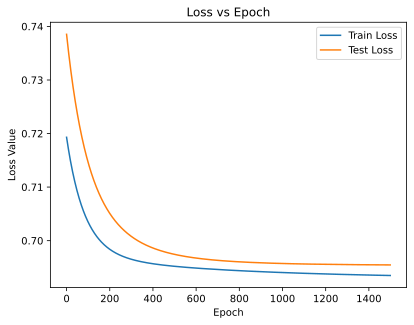

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_values, loss_values_train, label="Train Loss")
ax.plot(epoch_values, loss_values_test, label="Test Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_title("Loss vs Epoch")

ax.legend()

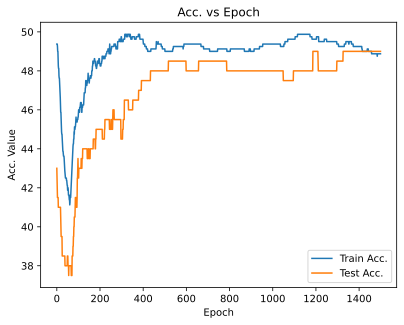

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_values, accuracy_values_train, label="Train Acc.")
ax.plot(epoch_values, accuracy_values_test, label="Test Acc.")

ax.set_xlabel("Epoch")
ax.set_ylabel("Acc. Value")
ax.set_title("Acc. vs Epoch")

ax.legend()

## Plotting Decision Boundary

In [ ]:
n_grids_dim = 2000

fig, ax = plt.subplots(ncols=2, figsize=(6.4*2, 4.8))

plot_decision_boundary(model=model, X=X_train, y=y_train, fig=fig, ax=ax[0],
                       n_grids_dim=n_grids_dim)
plot_decision_boundary(model=model, X=X_test, y=y_test, fig=fig, ax=ax[1],
                       n_grids_dim=n_grids_dim)

fig.suptitle("Train and Test Decision Boundaries")

ax[0].set_title("Train Decision Boundary")
ax[1].set_title("Test Decision Boundary")

ax[0].set_xlabel("X1")
ax[1].set_xlabel("X1")

ax[0].set_ylabel("X2")

Text(0, 0.5, 'X2')

# Model V2

## Creating a Model

In [ ]:
class CircleModelV2(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(x)))
        return z

In [ ]:
model = CircleModelV2()
model.to(device)

print(next(model.parameters()).device)

cpu


## Define Loss Function and Optimizer

In [ ]:
loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

## Training Model

In [ ]:
number_epochs = 1500

epoch_values = [None] * number_epochs
loss_values_train = [None] * number_epochs
loss_values_test = [None] * number_epochs
accuracy_values_train = [None] * number_epochs
accuracy_values_test = [None] * number_epochs

for index_epoch in range(number_epochs):

    model.train()

    y_logits_train = model(X_train).squeeze()
    y_preds_train = torch.round(torch.sigmoid(y_logits_train))

    loss_value_train = loss_function(y_logits_train, y_train)
    accuracy_value_train = calculate_accuracy(y_pred=y_preds_train,
                                              y_true=y_train)

    optimizer.zero_grad()
    loss_value_train.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))
        loss_value_test = loss_function(y_logits_test, y_test)
        accuracy_value_test = calculate_accuracy(y_pred=y_preds_test,
                                                 y_true=y_test)

    epoch_values[index_epoch] = index_epoch
    loss_values_train[index_epoch] = loss_value_train.item()
    loss_values_test[index_epoch] =  loss_value_test.item()
    accuracy_values_train[index_epoch] = accuracy_value_train
    accuracy_values_test[index_epoch] = accuracy_value_test

    if index_epoch % 50 == 0:
        train_string = f"Train Loss: {loss_value_train.item():.4f} | Train Acc.: {accuracy_value_train:.4f}"
        test_string = f"Test Loss: {loss_value_test.item():.4f} | Test Acc.: {accuracy_value_test:.4f}"
        print(f" Epoch: {index_epoch:<5d} | {train_string} | {test_string}")

 Epoch: 0     | Train Loss: 0.7031 | Train Acc.: 48.8750 | Test Loss: 0.6894 | Test Acc.: 54.5000
 Epoch: 50    | Train Loss: 0.6985 | Train Acc.: 48.8750 | Test Loss: 0.6894 | Test Acc.: 54.5000
 Epoch: 100   | Train Loss: 0.6960 | Train Acc.: 55.0000 | Test Loss: 0.6902 | Test Acc.: 62.5000
 Epoch: 150   | Train Loss: 0.6947 | Train Acc.: 52.7500 | Test Loss: 0.6912 | Test Acc.: 57.0000
 Epoch: 200   | Train Loss: 0.6940 | Train Acc.: 51.1250 | Test Loss: 0.6922 | Test Acc.: 53.5000
 Epoch: 250   | Train Loss: 0.6935 | Train Acc.: 50.5000 | Test Loss: 0.6931 | Test Acc.: 50.0000
 Epoch: 300   | Train Loss: 0.6933 | Train Acc.: 50.6250 | Test Loss: 0.6938 | Test Acc.: 45.5000
 Epoch: 350   | Train Loss: 0.6932 | Train Acc.: 50.0000 | Test Loss: 0.6943 | Test Acc.: 42.5000
 Epoch: 400   | Train Loss: 0.6931 | Train Acc.: 48.6250 | Test Loss: 0.6947 | Test Acc.: 44.5000
 Epoch: 450   | Train Loss: 0.6930 | Train Acc.: 47.6250 | Test Loss: 0.6950 | Test Acc.: 44.0000
 Epoch: 500   | Trai

In [ ]:
epoch_values = torch.Tensor(epoch_values).cpu().numpy()
loss_values_train = torch.Tensor(loss_values_train).cpu().numpy()
loss_values_test = torch.Tensor(loss_values_test).cpu().numpy()
accuracy_values_train = torch.Tensor(accuracy_values_train).cpu().numpy()
accuracy_values_test = torch.Tensor(accuracy_values_test).cpu().numpy()

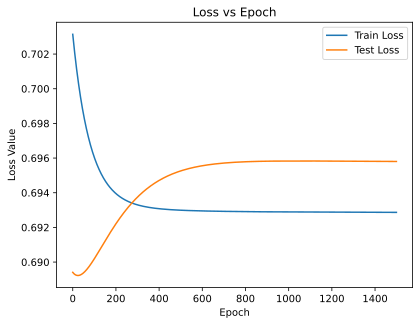

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_values, loss_values_train, label="Train Loss")
ax.plot(epoch_values, loss_values_test, label="Test Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_title("Loss vs Epoch")

ax.legend()

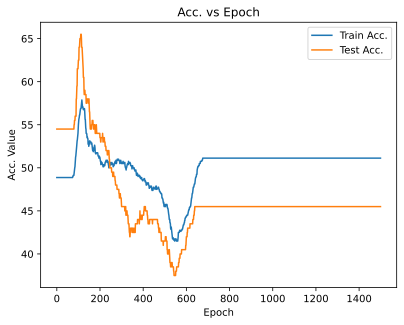

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_values, accuracy_values_train, label="Train Acc.")
ax.plot(epoch_values, accuracy_values_test, label="Test Acc.")

ax.set_xlabel("Epoch")
ax.set_ylabel("Acc. Value")
ax.set_title("Acc. vs Epoch")

ax.legend()

## Plotting Decision Boundary

Text(0, 0.5, 'X2')

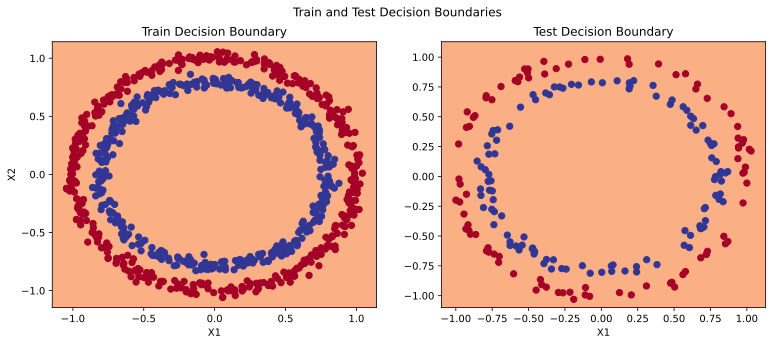

In [ ]:
n_grids_dim = 2000

fig, ax = plt.subplots(ncols=2, figsize=(6.4*2, 4.8))

plot_decision_boundary(model=model, X=X_train, y=y_train, fig=fig, ax=ax[0],
                       n_grids_dim=n_grids_dim)
plot_decision_boundary(model=model, X=X_test, y=y_test, fig=fig, ax=ax[1],
                       n_grids_dim=n_grids_dim)

fig.suptitle("Train and Test Decision Boundaries")

ax[0].set_title("Train Decision Boundary")
ax[1].set_title("Test Decision Boundary")

ax[0].set_xlabel("X1")
ax[1].set_xlabel("X1")

ax[0].set_ylabel("X2")

# Model V3

## Creating a Model

In [ ]:
class CircleModelV3(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        self.layer_stack = nn.Sequential(
            self.linear_layer_1,
            self.relu,
            self.linear_layer_2,
            self.relu,
            self.linear_layer_3
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.layer_stack(x)
        return z

In [ ]:
model = CircleModelV3()
model.to(device)

print(next(model.parameters()).device)

cpu


## Defining Loss Function and Optimizer

In [ ]:
loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

## Training Model

In [ ]:
number_epochs = 15000

epoch_values = [None] * number_epochs
loss_values_train = [None] * number_epochs
loss_values_test = [None] * number_epochs
accuracy_values_train = [None] * number_epochs
accuracy_values_test = [None] * number_epochs

for index_epoch in range(number_epochs):

    model.train()

    y_logits_train = model(X_train).squeeze()
    y_preds_train = torch.round(torch.sigmoid(y_logits_train))

    loss_value_train = loss_function(y_logits_train, y_train)
    accuracy_value_train = calculate_accuracy(y_pred=y_preds_train,
                                              y_true=y_train)

    optimizer.zero_grad()
    loss_value_train.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))
        loss_value_test = loss_function(y_logits_test, y_test)
        accuracy_value_test = calculate_accuracy(y_pred=y_preds_test,
                                                 y_true=y_test)

    epoch_values[index_epoch] = index_epoch
    loss_values_train[index_epoch] = loss_value_train.item()
    loss_values_test[index_epoch] =  loss_value_test.item()
    accuracy_values_train[index_epoch] = accuracy_value_train
    accuracy_values_test[index_epoch] = accuracy_value_test

    if index_epoch % 50 == 0:
        train_string = f"Train Loss: {loss_value_train.item():.4f} | Train Acc.: {accuracy_value_train:.4f}"
        test_string = f"Test Loss: {loss_value_test.item():.4f} | Test Acc.: {accuracy_value_test:.4f}"
        print(f" Epoch: {index_epoch:<5d} | {train_string} | {test_string}")

 Epoch: 0     | Train Loss: 0.6920 | Train Acc.: 51.1250 | Test Loss: 0.7004 | Test Acc.: 45.5000
 Epoch: 50    | Train Loss: 0.6917 | Train Acc.: 51.1250 | Test Loss: 0.6997 | Test Acc.: 45.5000
 Epoch: 100   | Train Loss: 0.6915 | Train Acc.: 51.1250 | Test Loss: 0.6990 | Test Acc.: 45.5000
 Epoch: 150   | Train Loss: 0.6913 | Train Acc.: 51.1250 | Test Loss: 0.6985 | Test Acc.: 45.5000
 Epoch: 200   | Train Loss: 0.6911 | Train Acc.: 51.1250 | Test Loss: 0.6980 | Test Acc.: 45.5000
 Epoch: 250   | Train Loss: 0.6909 | Train Acc.: 51.1250 | Test Loss: 0.6975 | Test Acc.: 45.5000
 Epoch: 300   | Train Loss: 0.6908 | Train Acc.: 51.1250 | Test Loss: 0.6971 | Test Acc.: 45.5000
 Epoch: 350   | Train Loss: 0.6906 | Train Acc.: 51.1250 | Test Loss: 0.6968 | Test Acc.: 45.5000
 Epoch: 400   | Train Loss: 0.6905 | Train Acc.: 51.1250 | Test Loss: 0.6965 | Test Acc.: 45.5000
 Epoch: 450   | Train Loss: 0.6904 | Train Acc.: 51.1250 | Test Loss: 0.6963 | Test Acc.: 45.5000
 Epoch: 500   | Trai

In [ ]:
epoch_values = torch.Tensor(epoch_values).cpu().numpy()
loss_values_train = torch.Tensor(loss_values_train).cpu().numpy()
loss_values_test = torch.Tensor(loss_values_test).cpu().numpy()
accuracy_values_train = torch.Tensor(accuracy_values_train).cpu().numpy()
accuracy_values_test = torch.Tensor(accuracy_values_test).cpu().numpy()

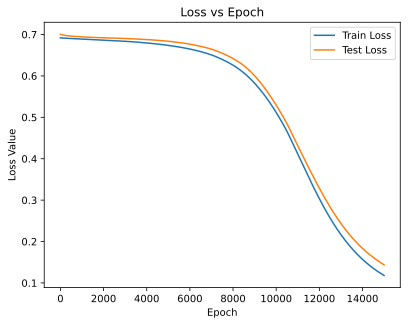

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_values, loss_values_train, label="Train Loss")
ax.plot(epoch_values, loss_values_test, label="Test Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_title("Loss vs Epoch")

ax.legend()

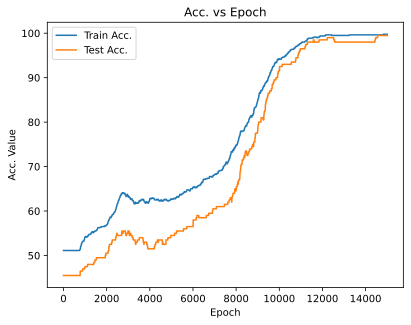

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_values, accuracy_values_train, label="Train Acc.")
ax.plot(epoch_values, accuracy_values_test, label="Test Acc.")

ax.set_xlabel("Epoch")
ax.set_ylabel("Acc. Value")
ax.set_title("Acc. vs Epoch")

ax.legend()

## Plotting Decision Boundary

In [ ]:
n_grids_dim = 2000

fig, ax = plt.subplots(ncols=2, figsize=(6.4*2, 4.8))

plot_decision_boundary(model=model, X=X_train, y=y_train, fig=fig, ax=ax[0],
                       n_grids_dim=n_grids_dim)
plot_decision_boundary(model=model, X=X_test, y=y_test, fig=fig, ax=ax[1],
                       n_grids_dim=n_grids_dim)

fig.suptitle("Train and Test Decision Boundaries")

ax[0].set_title("Train Decision Boundary")
ax[1].set_title("Test Decision Boundary")

ax[0].set_xlabel("X1")
ax[1].set_xlabel("X1")

ax[0].set_ylabel("X2")

Text(0, 0.5, 'X2')